<a href="https://colab.research.google.com/github/vedthebest/Pneumonia-Detection/blob/main/mobilenetv2_cl_loc_CV1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 14.6 MB/s 


In [3]:
# Imports
import os
import cv2
import glob
import time
import pydicom
import skimage
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import feature, filters
%matplotlib inline

from functools import partial
from collections import defaultdict
from joblib import Parallel, delayed
from lightgbm import LGBMClassifier
from tqdm import tqdm

# Tensorflow / Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras import Model
from tensorflow.keras.applications.vgg16 import VGG16
from keras import models
from keras import layers

# sklearn
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV

sns.set_style('whitegrid')
np.warnings.filterwarnings('ignore')

In [4]:
#load merged_df.pkl. This contains all merged data from both CSV files for training.
merged_df = pd.read_pickle('/content/drive/MyDrive/Colab/capstoneCV1/pklfiles/merged_df.pkl')

In [5]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   patientId           30227 non-null  object  
 1   x                   9555 non-null   float64 
 2   y                   9555 non-null   float64 
 3   width               9555 non-null   float64 
 4   height              9555 non-null   float64 
 5   Target              30227 non-null  int64   
 6   class               30227 non-null  object  
 7   y_max               9555 non-null   float64 
 8   x_max               9555 non-null   float64 
 9   Modality            30227 non-null  object  
 10  ConversionType      30227 non-null  object  
 11  PatientSex          30227 non-null  object  
 12  PatientAge          30227 non-null  int64   
 13  Body Part Examined  30227 non-null  object  
 14  ViewPosition        30227 non-null  object  
 15  Rows                30227 non-null  

In [6]:
cd "/content/drive/MyDrive/Colab/capstoneCV1/data"

/content/drive/MyDrive/Colab/capstoneCV1/data


In [7]:
# Reference image directories
trainImagesPath = "stage_2_train_images"
testImagesPath = "stage_2_test_images"

labelsPath = "stage_2_train_labels.csv"
classInfoPath = "stage_2_detailed_class_info.csv"
# Creating an array of the test & training file paths
#trainFilepaths = glob.glob(f"{trainImagesPath}/*.dcm")
#testFilepaths = glob.glob(f"{testImagesPath}/*.dcm")

In [8]:
#drop duplicates
new_df=merged_df.drop_duplicates(subset='patientId',keep='first',inplace=False)

In [9]:
new_df.shape

(26684, 19)

In [10]:
#fill na with 0 for x,y,x_max,y_max
new_df['x']=new_df['x'].fillna(0)

In [11]:
new_df['y']=new_df['y'].fillna(0)
new_df['x_max']=new_df['x_max'].fillna(0)
new_df['y_max']=new_df['y_max'].fillna(0)
new_df['width']=new_df['width'].fillna(0)
new_df['height']=new_df['height'].fillna(0)

In [12]:
train_data_x=[]
train_class_y=[]
train_bbox_y=[]

In [13]:
IMAGE_HEIGHT=1024
IMAGE_WIDTH=1024
RESIZE_HEIGHT=128
RESIZE_WIDTH=128
X_SCALE=RESIZE_HEIGHT/IMAGE_HEIGHT
Y_SCALE=RESIZE_WIDTH/IMAGE_WIDTH

In [22]:
new_df['Columns'].isna().sum()

0

FetchImageData function reads files, resizes them to (128,128) and normalizes them. The class of the data and their bounding box are filled in respective data structures.

In [25]:
def fetchImageData(df):
    for index, row in df.iterrows():
        pid = row['patientId']
        classlabel = row["Target"]
        file = trainImagesPath+'/'+pid+'.dcm'
        image = pydicom.read_file(file).pixel_array
        image = cv2.resize(image, (128, 128))
        image=image/255
        
        bb_x=row['x']*X_SCALE
        bb_y=row['y']*Y_SCALE
        bb_xmax=row['x_max']*X_SCALE
        bb_ymax=row['y_max']*Y_SCALE
        bb_tuple=(bb_x/255,bb_y/255,bb_xmax/255,bb_ymax/255)
        #bb_tuple=(bb_x,bb_y,bb_xmax,bb_ymax)
        #print(bb_tuple)
        train_bbox_y.append(bb_tuple)
        train_data_x.append(image)
        train_class_y.append(classlabel)
      


In [26]:
fetchImageData(new_df[:10000])

In [ ]:
len(train_bbox_y)

27658

In [27]:
train_X = np.array(train_data_x) # Convert to np.array
train_X_rgb = np.repeat(train_X[..., np.newaxis], 3, -1) # Reshape into rgb format

In [ ]:
len(train_X_rgb)

27658

In [ ]:
len(train_X_rgb)

27658

In [32]:
x_train=train_X_rgb[:9000]
y_train=np.array(train_class_y[:9000])
y_bbox_train=np.array(train_bbox_y[:9000])

In [33]:
x_val=train_X_rgb[9000:12000]
y_val=np.array(train_class_y[9000:12000])
y_bbox_val=np.array(train_bbox_y[9000:12000])

In [34]:
np.isnan(y_bbox_train).sum()

0

In [53]:
#read test 4 images for evaluation
testImagesPath = "stage_2_test_images"
testFilepaths = glob.glob(f"{testImagesPath}/*.dcm")

In [54]:
len(testFilepaths)

3000

In [56]:
"""
@Description: This decodes an image by reading the pixel array, resizing it into the correct format and
              normalising the pixels

@Inputs:
    - filePath: This is the filepath of the image that we want to decode

@Output:
    - img: This is the image after it has been decoded
"""
def decodeImage(filePath):
    image = pydicom.read_file(filePath).pixel_array
    image = cv2.resize(image, (128, 128))
    return (image/255)

In [57]:
# Get our test x in the correct shape for NN
test_X = []

for filePath in tqdm(testFilepaths[:100]):
    img_test = decodeImage(filePath) # Decode & Resize
    test_X.append(img_test)

test_X = np.array(test_X) # Convert to np array
test_X_rgb = np.repeat(test_X[..., np.newaxis], 3, -1) # Reshape into rgb format

100%|██████████| 100/100 [00:53<00:00,  1.88it/s]


In [58]:
len(test_X_rgb)

100

**MobileNet V2 based model.**
Sigmoid layer with 1 dense layer for classification.
1 dense layer with relu for regression and bbox detection.

In [28]:
# These our our scoring metrics that are going to be used to evaluate our models
METRICS = ['accuracy', 
         #  tf.keras.metrics.Precision(name='precision')] 
           tf.keras.metrics.Recall(name='recall')] 
         #  tf.keras.metrics.AUC(name='AUC')]

In [29]:
# Define our callback functions to pass when fitting our NNs
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5", save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

In [30]:
#build model with classification and localization
def build_mn_cl_model():
  model = tf.keras.Sequential()
  model.add(tf.keras.applications.MobileNetV2(include_top = False, weights="imagenet", input_shape=(128, 128, 3)))
  model.layers[0].trainable = False
 # print(model.layers[90].output_shape)
  #print(model.layers[90].name)
  chopped_mobilenet = Model(inputs=[model.input], outputs=[model.output]) #get_layer('Conv1')
  classification_output=tf.keras.layers.GlobalAveragePooling2D()(chopped_mobilenet.output)
  classification_output = Dense(units=1, activation='sigmoid')(classification_output)
  localization_output = Flatten()(chopped_mobilenet.output)
  localization_output = Dense(units=4, activation='relu')(localization_output)
  model = Model(inputs=[chopped_mobilenet.input], outputs=[classification_output, localization_output])
  model.summary()
  return model

In [31]:
mn_cl_model=build_mn_cl_model()
mn_cl_model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')

9420800/9406464 [==============================] - 0s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mobilenetv2_1.00_128_input (In  [(None, 128, 128, 3  0          []                               
 putLayer)                      )]                                                                
                                                                                                  
 mobilenetv2_1.00_128 (Function  (None, 4, 4, 1280)  2257984     ['mobilenetv2_1.00_128_input[0][0
 al)                                                             ]']                              
                                                                                                  
 global_average_pooling2d (Glob  (None, 1280)        0           ['mobilenetv2_1.00_128[0][0]']   
 alAveragePooling2D)         

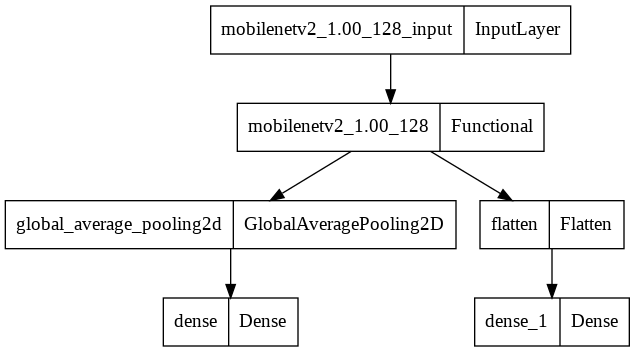

In [49]:
tf.keras.utils.plot_model(mn_cl_model)

In [36]:
history_mn_cl = mn_cl_model.fit(x_train, 
                          [y_train,y_bbox_train],  
                          epochs = 30, 
                          validation_data=(x_val,[y_val,y_bbox_val]),
                          #validation_split = 0.20, 
                          #class_weight = classWeight,
                          batch_size = 64)
                          
#callbacks = [checkpoint_cb, early_stopping_cb, lr_scheduler],verbose=True)

Epoch 1/30
141/141 [==============================] - 72s 511ms/step - loss: 1.8726 - dense_loss: 0.3875 - dense_1_loss: 1.4850 - dense_accuracy: 0.8251 - dense_1_accuracy: 0.7609 - val_loss: 1.0731 - val_dense_loss: 0.3617 - val_dense_1_loss: 0.7114 - val_dense_accuracy: 0.8536 - val_dense_1_accuracy: 0.8162
Epoch 2/30
141/141 [==============================] - 67s 476ms/step - loss: 1.8592 - dense_loss: 0.3741 - dense_1_loss: 1.4850 - dense_accuracy: 0.8301 - dense_1_accuracy: 0.7609 - val_loss: 1.0838 - val_dense_loss: 0.3724 - val_dense_1_loss: 0.7114 - val_dense_accuracy: 0.8457 - val_dense_1_accuracy: 0.8162
Epoch 3/30
141/141 [==============================] - 78s 556ms/step - loss: 1.8566 - dense_loss: 0.3716 - dense_1_loss: 1.4850 - dense_accuracy: 0.8318 - dense_1_accuracy: 0.7609 - val_loss: 1.0948 - val_dense_loss: 0.3834 - val_dense_1_loss: 0.7114 - val_dense_accuracy: 0.8299 - val_dense_1_accuracy: 0.8162
Epoch 4/30
141/141 [==============================] - 69s 492ms/ste

In [46]:
def plot_training_history(history, layer):
  plt.plot(history.history[layer+'_accuracy'])
  plt.plot(history.history['val_'+layer+'_accuracy'])
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['training', 'validation'], loc='best')
  plt.show()
  plt.plot(history.history[layer+'_loss'])
  plt.plot(history.history['val_'+layer+'_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['training', 'validation'], loc='best')
  plt.show()


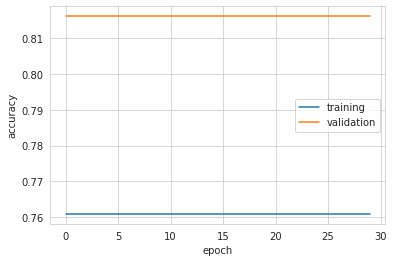

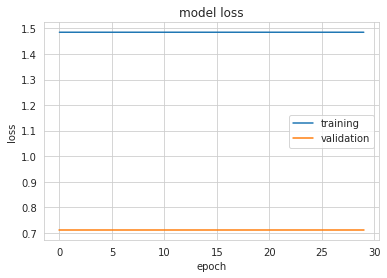

In [47]:
#the graph for Bounding box is plotted below.
plot_training_history(history_mn_cl,'dense_1')

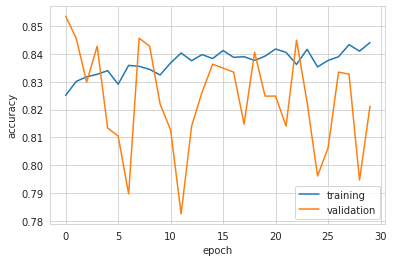

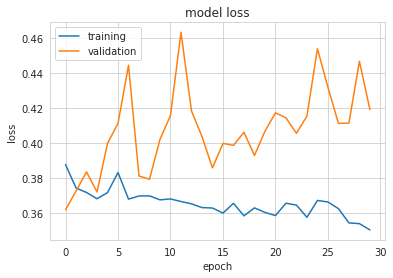

In [48]:
#the graph for classification is plotted below.
plot_training_history(history_mn_cl,'dense')

The graph for classification accuracy indicates that it remains steady for training data but varies significantly for validation data.  The accuracy for validation data oscillates a lot. The loss also oscilates a lot for validation while remaining more or less linear for training data. This also implies model has stopped learning after somepoint.

In case of bounding box detection , validation accuracy is better than training accuracy. The training loss is more than validation loss.
This could be due to class imbalance in the data.

In [59]:
def plot_with_box(image_data, bounding_box):
  fig,ax = plt.subplots(1)
  ax.imshow(image_data)
  # Creating a Rectangle patch for the changed one
  boxA = patches.Rectangle((bounding_box.xmin, bounding_box.ymin),
  bounding_box.xmax - bounding_box.xmin,
  bounding_box.ymax - bounding_box.ymin,
  linewidth=3, edgecolor='y', facecolor='none')
  # Add the patch to the Axes
  ax.add_patch(boxA)
  plt.show()


In [64]:
test_X_rgb[0].shape
img=np.array(test_X_rgb[0])
img.shape

(128, 128, 3)

In [81]:
#evaluate model on test data for 10 samples
#bbox=
pred = mn_cl_model.predict(test_X_rgb[:20])
pred

[array([[0.3627063 ],
        [0.03463289],
        [0.23905376],
        [0.02974758],
        [0.56317776],
        [0.6635158 ],
        [0.22526383],
        [0.4278333 ],
        [0.10553634],
        [0.01967329],
        [0.0362215 ],
        [0.02710772],
        [0.0036391 ],
        [0.02367693],
        [0.02000177],
        [0.05372041],
        [0.00192401],
        [0.11562335],
        [0.03377336],
        [0.09556413]], dtype=float32), array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]], dtype=float32)]

**Mobilenet V2 using output of layer 90 for classification and localization**

In [41]:
#build model with classification and localization
def build_mn_cl_loc_model():
  model=tf.keras.applications.MobileNetV2(include_top = False, weights="imagenet", input_shape=(128, 128, 3))
  model.layers[0].trainable = False
  chopped_mobilenet = Model(inputs=[model.input], outputs=[model.layers[90].output]) #get_layer('Conv1')
  classification_output=tf.keras.layers.GlobalAveragePooling2D()(chopped_mobilenet.output)
  classification_output = Dense(units=1, activation='sigmoid')(classification_output)
  localization_output = Flatten()(chopped_mobilenet.output)
  localization_output = Dense(units=4, activation='relu')(localization_output)
  model = Model(inputs=[chopped_mobilenet.input], outputs=[classification_output, localization_output])
  model.summary()
  return model

In [44]:
mn_cl_loc_model=build_mn_cl_loc_model()
mn_cl_loc_model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_3[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][0]']         

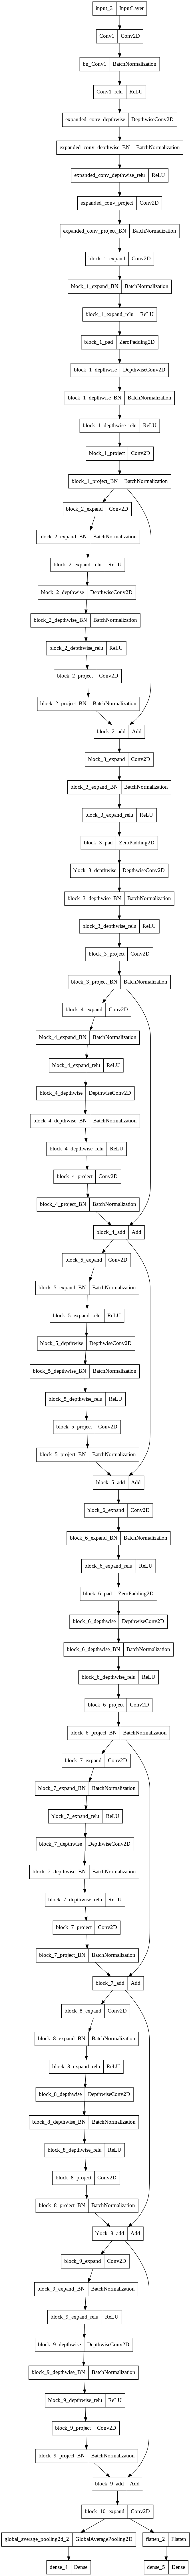

In [50]:
tf.keras.utils.plot_model(mn_cl_loc_model)

In [45]:
history_mn_cl_loc = mn_cl_loc_model.fit(x_train, 
                          [y_train,y_bbox_train],  
                          epochs = 30, 
                          validation_data=(x_val,[y_val,y_bbox_val]),
                          #validation_split = 0.20, 
                          #class_weight = classWeight,
                          batch_size = 64)

Epoch 1/30
141/141 [==============================] - 249s 2s/step - loss: 2.0026 - dense_4_loss: 0.4794 - dense_5_loss: 1.5232 - dense_4_accuracy: 0.7744 - dense_5_accuracy: 0.7581 - val_loss: 1.6807 - val_dense_4_loss: 0.9693 - val_dense_5_loss: 0.7114 - val_dense_4_accuracy: 0.3123 - val_dense_5_accuracy: 0.8162
Epoch 2/30
141/141 [==============================] - 243s 2s/step - loss: 1.8804 - dense_4_loss: 0.3954 - dense_5_loss: 1.4850 - dense_4_accuracy: 0.8182 - dense_5_accuracy: 0.7609 - val_loss: 1.1454 - val_dense_4_loss: 0.4340 - val_dense_5_loss: 0.7114 - val_dense_4_accuracy: 0.8062 - val_dense_5_accuracy: 0.8162
Epoch 3/30
141/141 [==============================] - 243s 2s/step - loss: 1.8464 - dense_4_loss: 0.3613 - dense_5_loss: 1.4850 - dense_4_accuracy: 0.8374 - dense_5_accuracy: 0.7609 - val_loss: 1.1934 - val_dense_4_loss: 0.4820 - val_dense_5_loss: 0.7114 - val_dense_4_accuracy: 0.8162 - val_dense_5_accuracy: 0.8162
Epoch 4/30
141/141 [=============================

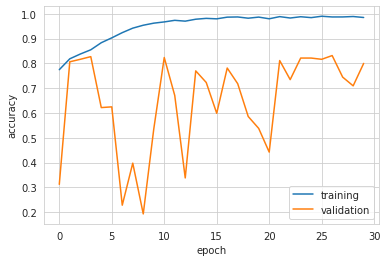

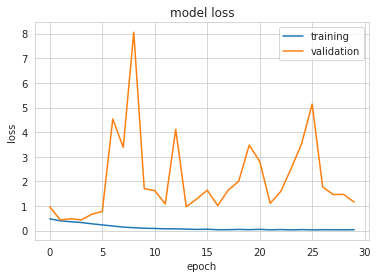

In [51]:
#classification graphs
plot_training_history(history_mn_cl_loc,'dense_4')

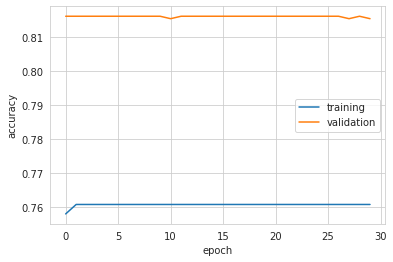

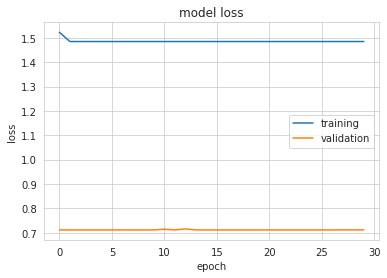

In [52]:
#regression graphs
plot_training_history(history_mn_cl_loc,'dense_5')

In this model 90th layer output is used for classification and localization.
The bbox graphs are linear in nature. The training loss is higher and accuracy lower where as the model performed better on validation data and hence resulted in better accuracy and lower less.  It points to model underfitting?.

The classification accuracy is more for training data and loss is low. However both accuracy and loss vary a lot for validation data.